<div style="text-align: center;">
    <span style="font-size:30px; font-weight: bold;">RBF Neural Network</span>
</div>

1. Load Data and Start Preprocessing

In [44]:
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data and start Preprocessing
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Scale pixel values to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshaping Data and Flattening Labels
x_train=x_train.reshape((x_train.shape[0],-1))
x_test=x_test.reshape((x_test.shape[0], -1))
y_train=y_train.flatten()
y_test=y_test.flatten()

# Normalization using StandardScaler
scale=StandardScaler()
x_train=scale.fit_transform(x_train)
x_test=scale.transform(x_test)

# PCA Application to keep 90% of total variance
pca_1=PCA(n_components=0.90)
x_train=pca_1.fit_transform(x_train)
x_test=pca_1.transform(x_test)

# Transform Labels into one Hot Encoding
one_hot_enc=OneHotEncoder(sparse_output=False)
y_train=one_hot_enc.fit_transform(y_train.reshape(-1,1))
y_test=one_hot_enc.transform(y_test.reshape(-1,1))

2. Define Choices for the Kernel

In [45]:
# Select RBF - Choices are Gaussian, Linear, Quadratic, Inverse Quadratic, Multiquadratic, Matern32, Matern52
def gaussian(a):
    return np.exp(-a**2)

def linear(a):
    return a

def quadratic(a):
    return a**2

def inverse_quadratic(a):
    return 1/(1 + a**2)

def multiquadric(a):
    return np.sqrt(1+a**2)

def inverse_multiquadric(a):
    return 1/np.sqrt(1 + a**2)

def matern32(a):
    return (1+np.sqrt(3)* a) * np.exp(-np.sqrt(3) * a)

def matern52(a):
    return (1+ np.sqrt(5)*a + (5/3) * a**2) * np.exp(-np.sqrt(5) *a)

3. Choose Number of Hidden Layer Neurons, Value for sigma and Use K-Means to get Cluster Centers

In [46]:
# Number of Hidden 
n_hidden = 5500
sigma = 100  # Choose Value for Sigma

# Uncomment to Compute Adaptive Sigma
'''def compute_adaptive_sigma(centers, data, k=10):
    n_centers = centers.shape[0]
    sigmas = np.zeros(n_centers)
    for i, center in enumerate(centers):
        distances = np.linalg.norm(data - center, axis=1)
        sigmas[i] = np.mean(np.sort(distances)[:k])
    return sigmas'''

# Perform K-Means to get Cneters of Clusters
kmeans = KMeans(n_clusters=n_hidden, random_state=42)
kmeans.fit(x_train)
centers = kmeans.cluster_centers_

4. Calculate Euclidean Distances - Apply Kernel - Calculate the output of the Hidden Layer

In [47]:
# Kernel
def rbf_kernel(x, centers, sigma, rbf_func):
    # Calculate the Euclidean distance between input x and each center and Apply selected RBF function
    distances =np.linalg.norm(x-centers, axis=1)
    return rbf_func(distances/sigma)

# Hidden Layer Implementation
def hiddenlayer_output(X,centers, sigma, rbf_func):
    n_samples = X.shape[0]
    n_hidden = centers.shape[0]
    hidden_layer_output = np.zeros((n_samples, n_hidden))
    
    # Calculate and Store the RBF activation for each sample and each center
    for i in range(n_samples):
        hidden_layer_output[i, :] = rbf_kernel(X[i], centers, sigma, rbf_func)
    
    return hidden_layer_output

5. Output Layer Implementation

In [48]:
def train_output_layer(hidden_output, y_train):
    n_hidden = hidden_output.shape[1]
    weights = np.zeros((n_hidden, 10)) # because all classes are 10

    for i in range(10):
        # Least squares method is used
        # Create a binary target for class 'i' (1 if the sample belongs to class c, 0 otherwise)
        y_binary = (y_train[:, i] == 1).astype(int) 
        
        # Weight Computation with the help of pseudo-inverse, W = (X^T * X)^-1 * X^T * y
        weights[:, i] = np.linalg.pinv(hidden_output).dot(y_binary)
    
    return weights

6. Train and Predict

In [49]:

# Uncomment for Adaptive Sigmas
#adaptive_sigmas = compute_adaptive_sigma(centers, x_train)


hiddenlayer_output_train = hiddenlayer_output(x_train, centers, sigma, gaussian) # modify for rbf kernel 
#hiddenlayer_output_train = hiddenlayer_output(x_train, centers, adaptive_sigmas, gaussian) # Uncomment for Adaptive Sigmas

# Train the output layer
output_weights = train_output_layer(hiddenlayer_output_train, y_train)


# Evaluate the accuracy of the model on test data
hidden_layer_output_test = hiddenlayer_output(x_test, centers, sigma, gaussian) # modify for rbf kernel
#hidden_layer_output_test = hiddenlayer_output(x_test, centers, adaptive_sigmas, gaussian)# Uncomment for Adaptive Sigmas  

def predict(hidden_output, output_weights):
    # Compute the dot product between the hidden layer output and the output weights
    scores = np.dot(hidden_output, output_weights)
    # The predicted class is the class with the highest score
    predicted_classes = np.argmax(scores, axis=1)
    return predicted_classes

# Make predictions
y_pred = predict(hidden_layer_output_test, output_weights)
y_train_pred = predict(hiddenlayer_output_train, output_weights)


def train_output_layer(hidden_output, y_train):
    output_weights = np.linalg.pinv(hidden_output).dot(y_train)
    return output_weights


6. Print Metrics

Training Accuracy: 66.98
Testing Accuracy: 54.23

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.63      0.63      1000
           1       0.62      0.68      0.65      1000
           2       0.46      0.38      0.41      1000
           3       0.40      0.32      0.36      1000
           4       0.47      0.42      0.44      1000
           5       0.49      0.43      0.46      1000
           6       0.51      0.68      0.58      1000
           7       0.59      0.61      0.60      1000
           8       0.60      0.69      0.65      1000
           9       0.59      0.58      0.58      1000

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.54      0.54      0.54     10000



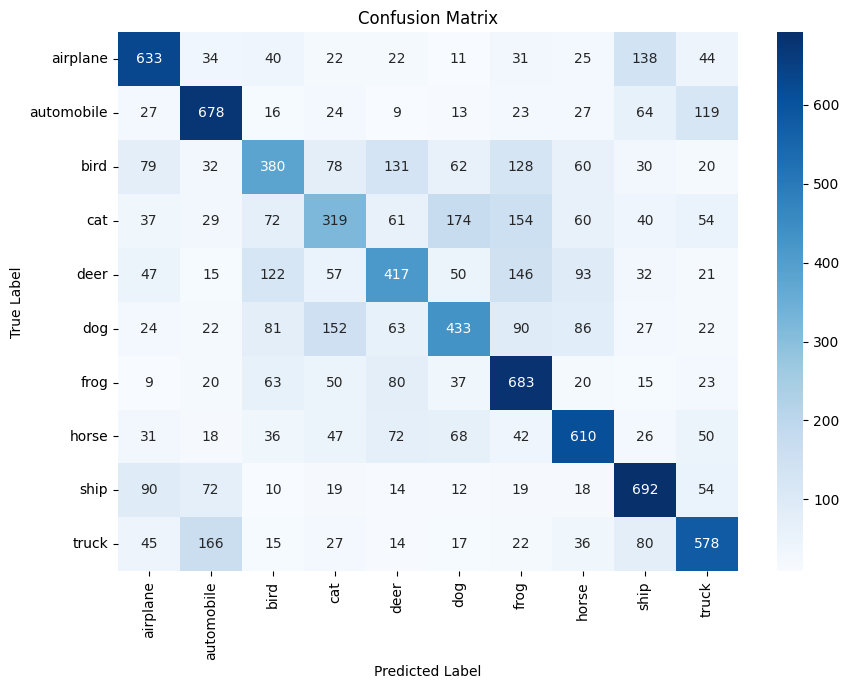

In [50]:
# Evaluate the accuracy of the model
train_accuracy = accuracy_score(y_train.argmax(axis=1), y_train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}")

accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
print(f"Testing Accuracy: {accuracy*100:.2f}")

# Classification report (precision, recall, f1-score for each class)
print("\nClassification Report:\n", classification_report(y_test.argmax(axis=1), y_pred))

# Visualize the confusion matrix
def plot_confusion_matrix(y_test,y_pred, class_names):
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Visualize the confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1), y_pred, class_names)
